In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

In [3]:
from sklearn.metrics import *
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

In [4]:
df = pd.read_csv("train.csv")

In [5]:
# creo una copia su cui lavorare mantenendo inalterato l'originale
dfm = df.copy()

In [6]:
dfm['time_signature'] = dfm['time_signature'].fillna(dfm['time_signature'].mode()[0])

In [7]:
# crea un df con due colonne genre e n. di missing values per ogni genre, ed aggiunge l'indice alle righe
missing_counts = dfm.groupby('genre')['mode'].apply(lambda x: x.isnull().sum()).reset_index()

# rinomino le colonne del df missing_counts, che orasi chiameranno genre e missing_count invece che genre e mode
missing_counts.columns = ['genre', 'missing_count']

# Crea il DataFrame df1 privo di missing values
df1 = dfm[dfm['mode'].notnull()]

# Calcola le frequenze di 0 e 1 per ciascun genere in df1
# frequencies_by_genre è un df che contiene le frequenze di 0 e 1 per ciascun genere
frequencies_by_genre = df1.groupby('genre')['mode'].value_counts(normalize=True).unstack().fillna(0)

# Sostituisci i missing values con liste di 0 e 1 basate sulle frequenze per ogni genere
for genre in dfm['genre'].unique():
    # restituisce True se c'è un missing value in mode e se è il genere in questione
    missing_values = dfm['mode'].isnull() & (dfm['genre'] == genre)
    # seleziona la giusta riga e colonna del df missing_counts e restituisce il conteggio di missing values per quel genre
    missing_count = missing_counts[missing_counts['genre'] == genre]['missing_count'].values[0]

    if missing_count > 0:
        # retituisce la coppia di frequenze per i valori 0 e 1 per il genre in questione
        frequencies = frequencies_by_genre.loc[genre]
        # crea un array di 0 e 1 estratti in base alle frequenze del genere, utilizzate come probabilità
        replacement_values = np.random.choice([0, 1], size=missing_count, p=frequencies)
        # sostituisce i missing values (True) della colonna mode con i valori dell'array precedente
        dfm.loc[missing_values, 'mode'] = replacement_values

In [8]:
# il numero di missing values che popularity_confidence presenta ci spinge a preferire il drop della colonna intera
dfm = dfm.drop('popularity_confidence', axis=1)

In [9]:
# inoltre, dato il risultato delle correlzioni, notiamo che possiamo escludere dall'analisi feature_duration_ms in quanto ha
# una correlazione quasi pari a 1 con duration_msv
dfm = dfm.drop('features_duration_ms', axis=1)

In [10]:
# salvo il db con tutti i missing values trattati così da non dover rifare tutto ogni volta.
df.to_csv('dfm.csv')

In [11]:
# dfm = pd.read_csv("dfm.csv")

In [12]:
# rimuoviamo tutte le variabili categoriche
dfm = dfm.drop(['name', 'artists', 'album_name', 'genre'], axis=1)
# rimuoviamo le variabili binary ed ordinal
dfm.drop(['explicit', 'mode', 'key', 'time_signature'], axis=1, inplace=True)

In [13]:
dfm.head()

,duration_ms,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,n_beats,n_bars,processing
0,241760,46,0.690,0.513,-12.529,0.0975,0.302000,0.53600,0.281,0.6350,142.221,567.0,141.0,1.279305
1,444000,0,0.069,0.196,-24.801,0.0805,0.283000,0.93400,0.360,0.0336,75.596,617.0,155.0,2.367412
2,333506,3,0.363,0.854,-7.445,0.0397,0.000089,0.80000,0.262,0.4890,116.628,652.0,162.0,3.700483
3,269800,23,0.523,0.585,-5.607,0.0765,0.066400,0.00127,0.117,0.3850,140.880,619.0,155.0,1.279305
4,307651,25,0.643,0.687,-11.340,0.0539,0.000576,0.09690,0.299,0.6370,143.956,733.0,183.0,4.067086


In [14]:
# prima di procedere al clustering procediamo con la normalizzazione delle colonne
scaler = MinMaxScaler()
data = scaler.fit_transform(dfm)

# K-means clustering


In [15]:
%%time
sse_list = []
sil_list = []

for k in range(2, 51):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(data)
    sse_list.append(kmeans.inertia_)
    sil_list.append(silhouette_score(data, kmeans.labels_))

CPU times: total: 15min 52s
Wall time: 6min 44s


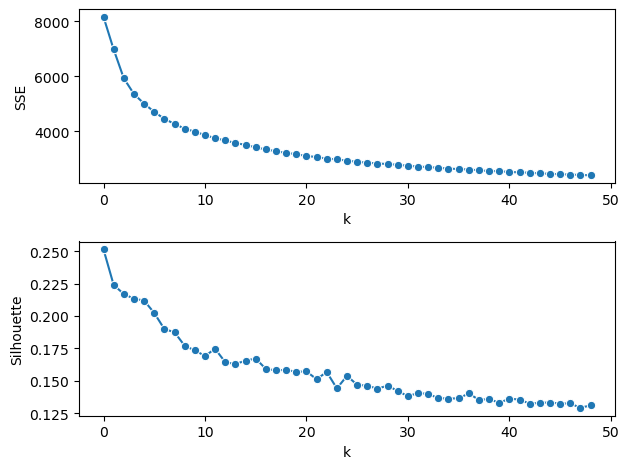

In [16]:
fig, axs = plt.subplots(2) # 1 row, 2 columns

sns.lineplot(x=range(len(sse_list)), y=sse_list, marker='o', ax=axs[0])
axs[0].set(xlabel='k', ylabel='SSE')
sns.lineplot(x=range(len(sil_list)), y=sil_list, marker='o', ax=axs[1])
axs[1].set(xlabel='k', ylabel='Silhouette')

plt.tight_layout() # Adjust the padding between and around subplots

Dal grafico SSE riusciamo ad individuare il gomito della funzione si colloca tra un valore k=6 e k=9, incrociando questo risultato con il grafico seguente, che spiega il coefficiente di silhouette, osserviamo che il massimo locale della silhouette si raggiunge per k=6. Adottiamo quindi questo valore nel proseguo della nostra analisi


In [17]:
kmeans = KMeans(init='k-means++', n_clusters=6, n_init=10, max_iter=100)
kmeans.fit(data)

KMeans(max_iter=100, n_clusters=6, n_init=10)

In [18]:
print('labels', np.unique(kmeans.labels_, return_counts=True))
print('sse', kmeans.inertia_)
print('silhouette', silhouette_score(data, kmeans.labels_))

labels (array([0, 1, 2, 3, 4, 5]), array([2217, 3863, 1687, 1605, 3932, 1696], dtype=int64))
sse 4998.254729834899
silhouette 0.2118792870082071


Dopo aver comunque condotto i test per valori di k da 6 a 9, otteniamo che, malgrado un naturale decremento della SSE, la silhouette che otteniamo per k = 6 è la migliore del campione.

In [19]:
'''
pca = PCA()
pca.fit(data)
feature_names = dfm.columns
'''

'\npca = PCA()\npca.fit(data)\nfeature_names = dfm.columns\n'

In [20]:
'''
# Explained variance ratio of each principal component
explained_var = pca.explained_variance_ratio_

# Plotting the explained variance ratios
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_var) + 1), explained_var, alpha=0.8, align='center')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio of Principal Components')
plt.grid(True)
plt.show()
'''


"\n# Explained variance ratio of each principal component\nexplained_var = pca.explained_variance_ratio_\n\n# Plotting the explained variance ratios\nplt.figure(figsize=(8, 6))\nplt.bar(range(1, len(explained_var) + 1), explained_var, alpha=0.8, align='center')\nplt.xlabel('Principal Component')\nplt.ylabel('Explained Variance Ratio')\nplt.title('Explained Variance Ratio of Principal Components')\nplt.grid(True)\nplt.show()\n"

La PCA condotta ci dice la prima componente principale spiega poco meno del 30% della varianza totale, quindi per ottenere un'analisi robusta senza perdere troppa informazione, possiamo decidere di prendere le prime 4 componenti per il proseguo della nostra analisi, che spiegano circa il 78% del totale.

In [21]:
# explained_var

NameError: name 'explained_var' is not defined

In [22]:
'''pca = PCA(n_components=4)  # Choose the number of components
pca.fit(data)

# Access the PCA components (principal axes in feature space)
components = pca.components_

# Access the PCA loadings (weights or coefficients)
 loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Assuming 'feature_names' contains your feature names (if available)
for i, component in enumerate(components):
    print(f"Principal Component {i+1}:")
    for j, feature in enumerate(feature_names):
        print(f"{feature}: {loadings[j, i]}")
    print()
'''


'pca = PCA(n_components=4)  # Choose the number of components\npca.fit(data)\n\n# Access the PCA components (principal axes in feature space)\ncomponents = pca.components_\n\n# Access the PCA loadings (weights or coefficients)\n loadings = pca.components_.T * np.sqrt(pca.explained_variance_)\n\n# Assuming \'feature_names\' contains your feature names (if available)\nfor i, component in enumerate(components):\n    print(f"Principal Component {i+1}:")\n    for j, feature in enumerate(feature_names):\n        print(f"{feature}: {loadings[j, i]}")\n    print()\n'

In [23]:
min_vals = np.min(dfm, axis=0)
max_vals = np.max(dfm, axis=0)
dfmn = (dfm - min_vals) / (max_vals - min_vals)

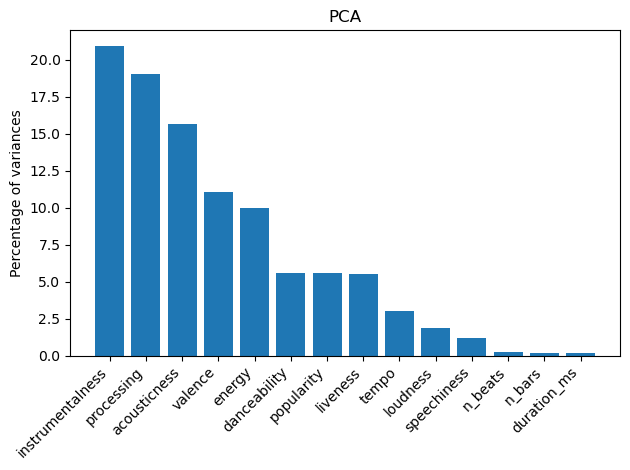

In [24]:
# Calcola la varianza di ogni colonna
variances = dfmn.var()

# Ordina il DataFrame in base alle varianze in ordine decrescente
variances_sorted = variances.sort_values(ascending=False)

# Calcola la varianza totale per normalizzare le percentuali
total_variance = variances_sorted.sum()

# Calcola le percentuali della varianza di ogni colonna
percentage_var = (variances_sorted / total_variance) * 100

# Creazione del grafico
plt.bar(percentage_var.index, percentage_var)
#plt.xlabel('Colonne')
plt.ylabel('Percentage of variances')
plt.title('PCA')
plt.xticks(rotation=45, ha='right')  # Rotazione dei nomi delle colonne per una migliore leggibilità
plt.tight_layout()  # Ottimizza la disposizione del grafico
plt.show()

Le variabili con varianza più ampia generalmente sono considerabili più significative e sono quelle che influenzano di più l'analisi. Questo dato ci può indicare su quali, tra le colonne del dataset, potrebbe essere più interessante condurre un'analisi.
In questo caso le variabili che terremo in considerazione sono le prime 5, dal momento che la discesa si fa più marcata nel passaggio tra quinta e sesta, dove il valore quasi dimezza.

In [25]:
dfmn['label'] = kmeans.labels_

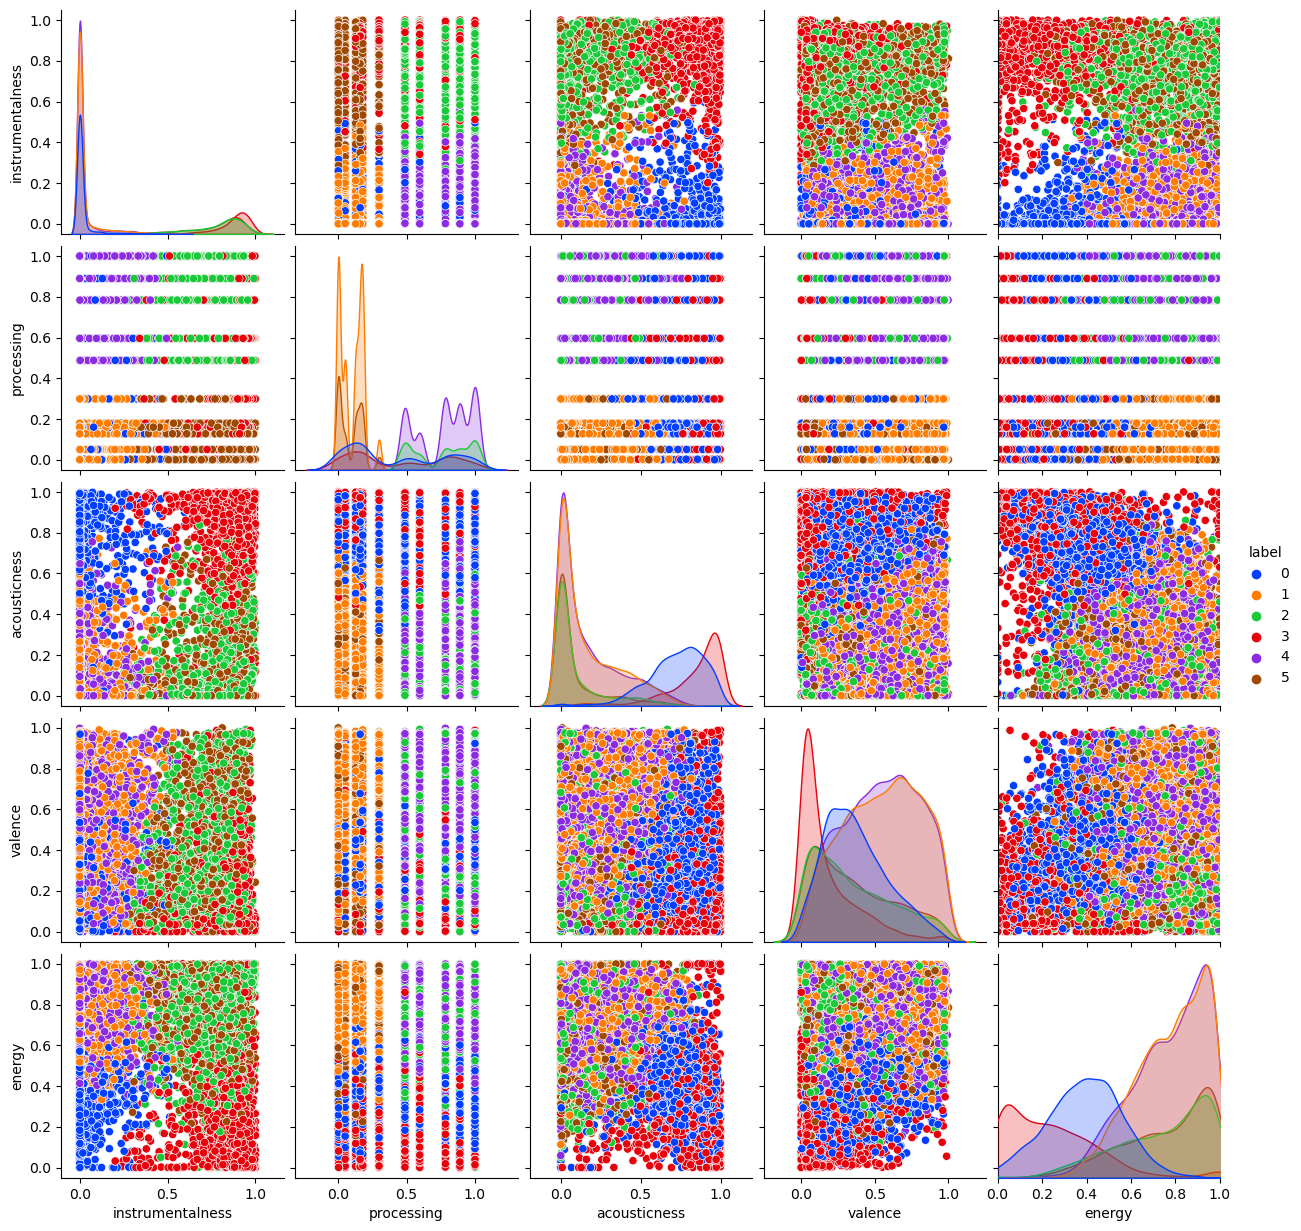

In [26]:
sns.pairplot(dfmn[['instrumentalness', 'processing', 'acousticness', 'valence', 'energy', 'label']], hue='label', diag_kind='kde', palette='bright')    # colorblind
plt.xlim(0, 1)
plt.show()

# DBSCAN

In [27]:
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

In [28]:
dist = pdist(data, 'euclidean')
dist = squareform(dist)

In [29]:
# "regola del pollice" -> prendere minpts pari al doppio della dimensionalità, o anche maggiore se questa è grande.
# nel nostro dataset abbiamo 14 colonne quindi k=32
k=32
kth_distances = []

for d in dist:  # dist è una matrice, d è l'array riga della matrice (d=riga n, n+1,...)
    index_kth_distance = np.argsort(d)[k]  # np.argsort(d) ordina gli elementi della riga d e li indicizza in ordine crescente, e prende il k-esimo indice
    kth_distances.append(d[index_kth_distance])  # prende l'elemento di d che ha l'indice di cui sopra

Coordinate del ginocchio: (14770, 0.45)


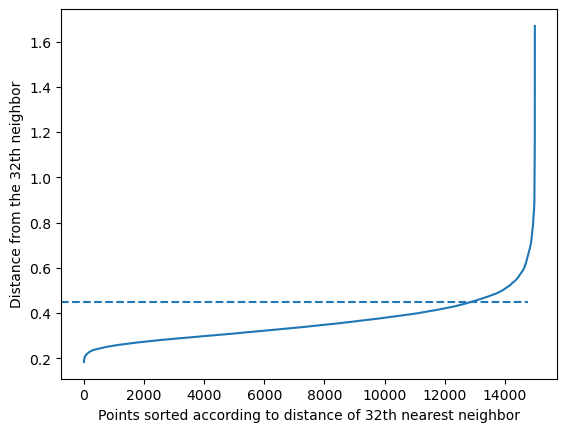

In [48]:
x = range(0, len(kth_distances))
y = sorted(kth_distances)
kn = KneeLocator(x, y, curve='convex', direction='increasing')
plt.plot(x, y)
plt.ylabel('Distance from the {}th neighbor'.format(k))
plt.xlabel('Points sorted according to distance of {}th nearest neighbor'.format(k))
knee_x = kn.knee
knee_y = 0.45
plt.axhline(knee_y, linestyle='dashed', xmax=(knee_x - plt.xlim()[0]) / (plt.xlim()[1] - plt.xlim()[0]))
print(f"Coordinate del ginocchio: ({knee_x}, {knee_y})")
plt.show()

In [44]:
dbscan = DBSCAN(eps=0.45, min_samples=32, metric='euclidean')
dbscan.fit(data)

hist, bins = np.histogram(dbscan.labels_, bins=range(-1, len(set(dbscan.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(data[dbscan.labels_ != -1], dbscan.labels_[dbscan.labels_ != -1]))

labels {-1: 453, 0: 14519, 1: 28, 2: 0}
silhouette 0.25001639929331154


Con il dbscan i risultati che otteniamo, nonostante il buon valore di silhouette, non sono convincenti e ciò si denota sopratutto dall'aspetto dei plot, dove i punti si overlappano molto e questo rende quasi impossibile riconoscere il secondo cluster ed i noise points sono perlopiù oscurati.

In [45]:
df_dbscan = dfm

In [46]:
df_dbscan['label']=dbscan.labels_

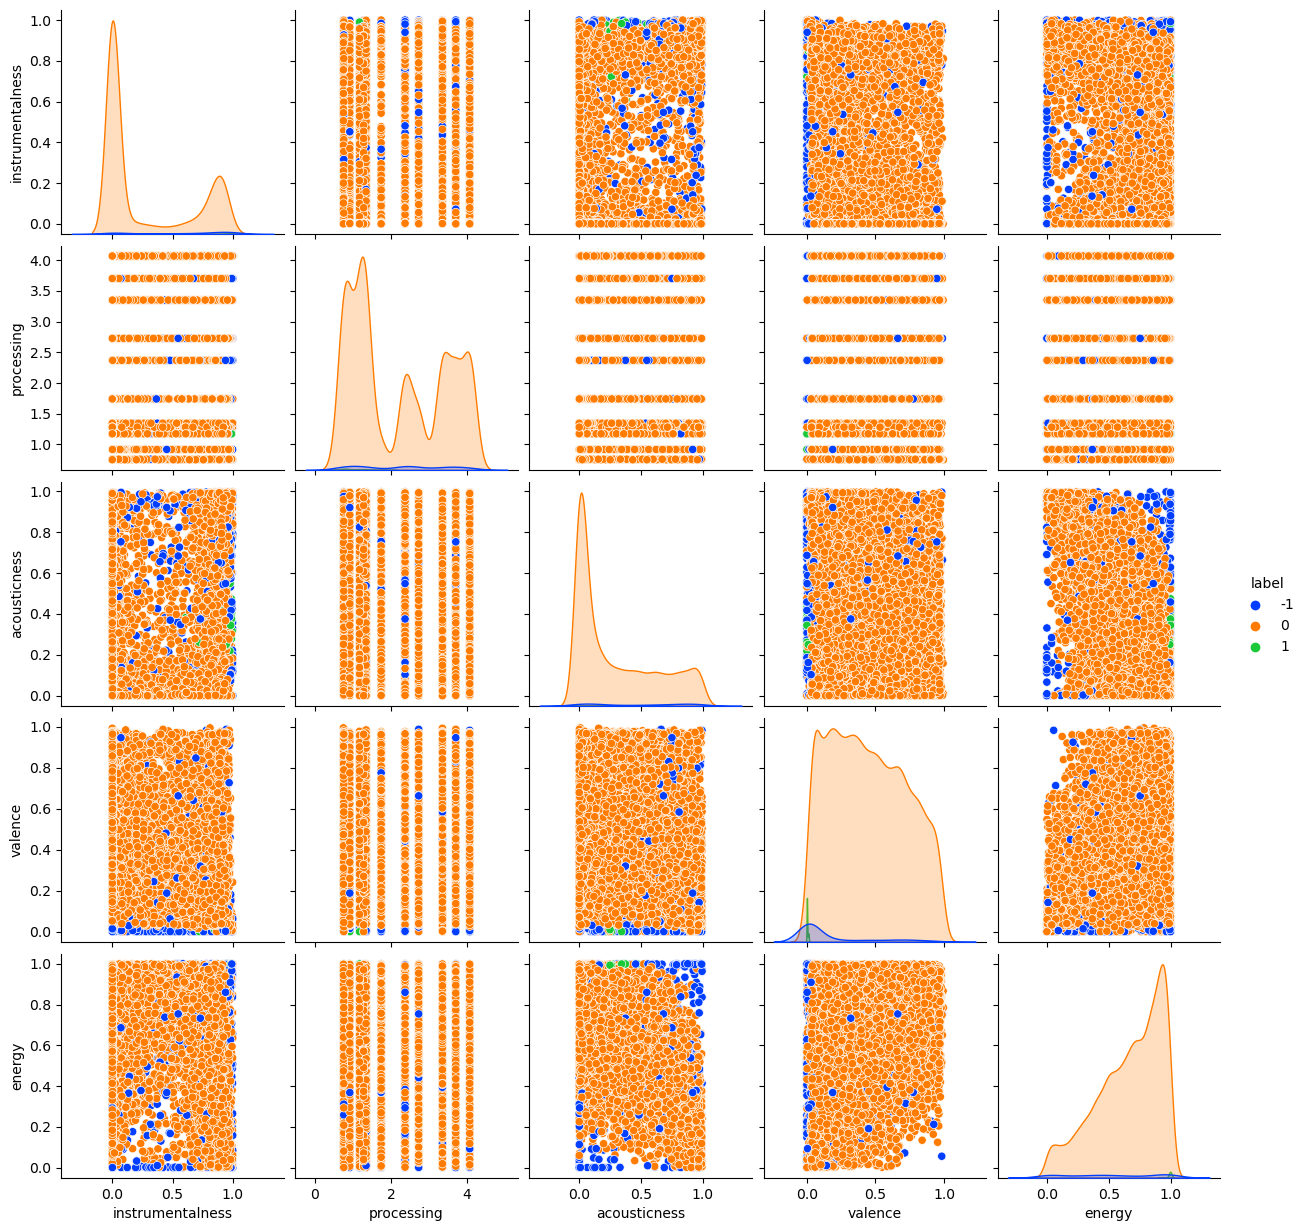

In [47]:
sns.pairplot(df_dbscan[['instrumentalness', 'processing', 'acousticness', 'valence', 'energy', 'label']], hue='label', diag_kind='kde', palette='bright')    # colorblind
plt.show()

# Hierarchical

In [50]:
def get_linkage_matrix(model):
    # Create linkage matrix 
    
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    return linkage_matrix

def plot_dendrogram(model, **kwargs):
    linkage_matrix = get_linkage_matrix(model)
    dendrogram(linkage_matrix, **kwargs)

In [51]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, metric='euclidean', linkage='complete')
model = model.fit(data)

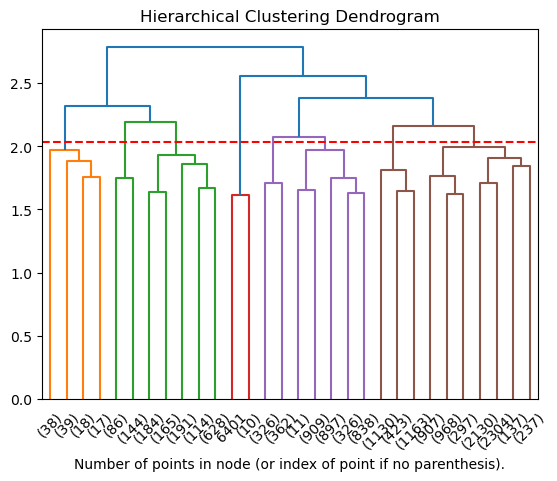

In [62]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="lastp", color_threshold=2.25)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.axhline(y=2.03, color='r', linestyle='--')
plt.show()

Da questo "taglio" che abbiamo deciso di fare, notiamo che il dataset può essere suddiviso in 5 cluster differenti.

In [60]:
Z = get_linkage_matrix(model)
labels = fcluster(Z, t=2.03, criterion='distance')

In [61]:
print('Silhouette', silhouette_score(data, labels))

Silhouette 0.13943292494511358


Dopo aver effettuato dei tentativi, mantenendo fisso il numero di cluster, otteniamo il miglior valore di silhouette per il taglio effettuato ad un'altezza pari a 2.03, dove silhouette = 0.13943292494511358